In [2]:
import sys
sys.path.append('./')

from NTdatasets.cumming.monocular import MultiDataset
from torch.utils.data import DataLoader, random_split, Subset

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
import tqdm

import numpy as np

device = torch.device('cuda:0')

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [3]:
# Load Data
expts = ['expt04']
datadir = './Mdata/'

batch_size = 2000

# we don't time embed to model the stimuli as a sequence with the transformer
dataset = MultiDataset(datadir=datadir, filenames=expts, include_MUs=False, time_embed=False)
print("%d cells, %d time steps."%(dataset.NC, dataset.NT))

train_inds = dataset.train_inds
val_inds = dataset.val_inds

train_ds = Subset(dataset, train_inds)
val_ds = Subset(dataset, val_inds)

train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=0)
valid_dl = DataLoader(val_ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=0)

len(train_ds), len(val_ds)

Loading ['expt04']
Loading expt04
11 cells, 362504 time steps.


(274739, 68780)

In [9]:
for i, X in enumerate(train_dl):
    print(X.keys())
    break

dict_keys(['stim', 'robs', 'dfs'])


# build the model

In [116]:
import torch
import torch.nn as nn

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation)

    def forward(self, src, src_mask=None, src_key_padding_mask=None, return_attentions=False):
        attn_output, attn_output_weights = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return (src, attn_output_weights) if return_attentions else src


class CustomTransformerEncoder(nn.TransformerEncoder):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__(encoder_layer, num_layers, norm)

    def forward(self, src, mask=None, src_key_padding_mask=None, return_attentions=False):
        output = src

        attentions = []
        for mod in self.layers:
            if return_attentions:
                # the attn here is made up by the model,
                # need to figure out the real way to do it
                output, attn = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask, return_attentions=True)
                attentions.append(attn)
            else:
                output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return (output, attentions) if return_attentions else output


class LinearPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=360):
        super(LinearPositionalEncoding, self).__init__()
        self.linear = nn.Linear(1, d_model, bias=False)

        # Create the position tensor (a sequence of 36 0s, 36 1s, 36 2s, ...)
        position = torch.div(torch.arange(max_len).unsqueeze(1), 36, rounding_mode='floor')
        self.register_buffer('position', position.float())

    def forward(self, x):
        x = x + self.linear(self.position[:x.size(0), :])
        return x


class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()

        # Positional encoding
        self.pos_encoder = LinearPositionalEncoding(d_model)

        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(d_model)
        
        # Transformer encoder
        encoder_layer = CustomTransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = CustomTransformerEncoder(encoder_layer, num_layers)
        
        # Decoder
        self.decoder = nn.Linear(d_model, 110)

    def forward(self, src, return_attentions=False):
        # Positional encoding
        src = self.pos_encoder(src)

        # Batch normalization
        src = self.batch_norm(src)
        
        # Transformer encoder
        src = self.transformer_encoder(src, return_attentions=return_attentions)
        if return_attentions:
            src, attentions = src
        
        # Decoder
        output = self.decoder(src)
        
        return (output, attentions) if return_attentions else output

# Hyperparameters
ninp = 360   # embedding dimension
nhid = 256    # hidden dimension
nlayers = 2   # number of layers
nhead = 4     # number of attention heads
dropout = 0.1 # dropout rate
output_dim = 110 # output dimension (number of neurons)

# Create the model
model = TransformerModel(ninp, nhead, nlayers, nhid)
model = model.to(device)

# train the model

In [117]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters())

# Set desired sequence length
sequence_length = 360

# Loss function
criterion = nn.PoissonNLLLoss()

import torch.optim as optim

# Optimizer
l2_reg = 0.1
learning_rate = 0.01
optimizer = optim.AdamW(lr=learning_rate, 
                        weight_decay=l2_reg, 
                        params=model.parameters())

# Set desired sequence length
stim_length = 36
robs_length = 11
sequence_length = 360

# Loss function
criterion = nn.MSELoss() # MSE
#criterion = nn.PoissonNLLLoss() # Poisson

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dl):
        stims = batch['stim'].to(device)
        robs = batch['robs'].to(device) 
        
        # skip the batch if it does not divide evenly into the sequence length
        if len(stims.flatten()) % sequence_length != 0:
            continue
        
        # Reshape stims and robs
        batch_size = stims.shape[0]
        concat_len = 10
        stims = stims.view(-1, 36*concat_len)
        robs = robs.view(-1, 11*concat_len)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(stims)
        
        # Calculate the loss
        loss = criterion(outputs, robs)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate validation loss
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(valid_dl):
            stims = batch['stim'].to(device)
            robs = batch['robs'].to(device)

            # Reshape stims and robs
            batch_size = stims.shape[0]
            concat_len = 10
            stims = stims.view(-1, 36*concat_len)
            robs = robs.view(-1, 11*concat_len)

            # Forward pass
            outputs = model(stims)

            # Calculate the loss
            loss = criterion(outputs, robs)

            # Accumulate the validation loss
            valid_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_dl):.4f}, Validation Loss: {valid_loss / len(valid_dl):.4f}")

Epoch 1/10, Training Loss: 0.4667, Validation Loss: 0.3726
Epoch 2/10, Training Loss: 0.3708, Validation Loss: 0.3711
Epoch 3/10, Training Loss: 0.3680, Validation Loss: 0.3695
Epoch 4/10, Training Loss: 0.3672, Validation Loss: 0.3688
Epoch 5/10, Training Loss: 0.3668, Validation Loss: 0.3694
Epoch 6/10, Training Loss: 0.3667, Validation Loss: 0.3680
Epoch 7/10, Training Loss: 0.3666, Validation Loss: 0.3696
Epoch 8/10, Training Loss: 0.3667, Validation Loss: 0.3688
Epoch 9/10, Training Loss: 0.3666, Validation Loss: 0.3687
Epoch 10/10, Training Loss: 0.3665, Validation Loss: 0.3683


In [118]:
from sklearn.metrics import r2_score

model.eval()
all_true_robs = []
all_pred_robs = []

for batch in valid_dl:
    stims = batch['stim'].to(device)
    robs = batch['robs'].to(device)

    # skip the batch if it does not divide evenly into the sequence length
    if len(stims.flatten()) % sequence_length != 0:
        continue

    # Reshape stims and robs
    batch_size = stims.shape[0]
    concat_len = 10
    stims = stims.view(-1, 36*concat_len)
    robs = robs.view(-1, 11*concat_len)

    # Make predictions
    with torch.no_grad():
        pred_robs = model(stims)

    all_true_robs.extend(robs.cpu().numpy())
    all_pred_robs.extend(pred_robs.cpu().numpy())

all_true_robs = np.array(all_true_robs)
all_pred_robs = np.array(all_pred_robs)

r2 = r2_score(all_true_robs, all_pred_robs)
print(f"R2 score: {r2:.4f}")

R2 score: -0.0014


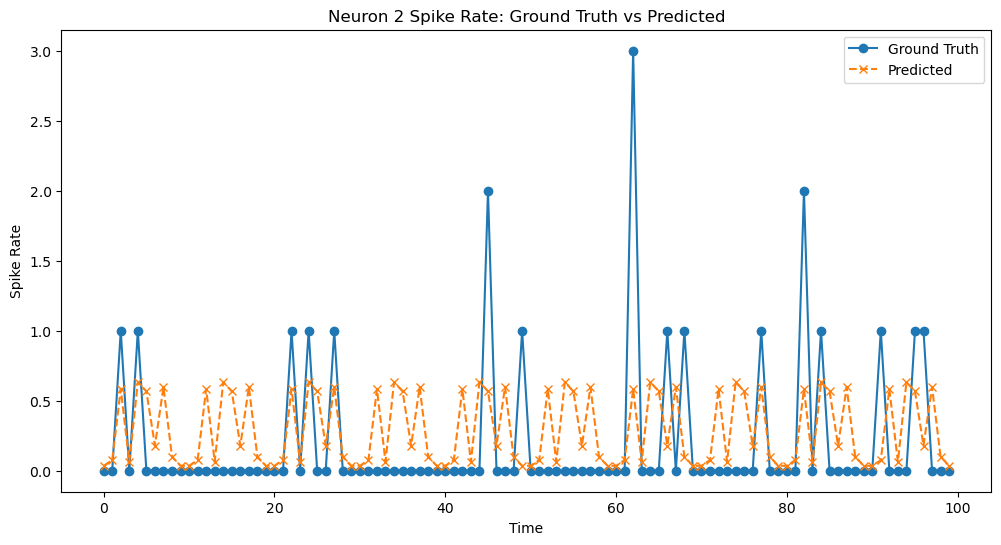

In [119]:
import matplotlib.pyplot as plt

def plot_robs_comparison_extended(true_robs, pred_robs, neuron_idx, sample_start_idx, num_frames=1000):
    plt.figure(figsize=(12, 6))
    true_robs_concat = true_robs[sample_start_idx:sample_start_idx+num_frames//concat_len, neuron_idx*concat_len:(neuron_idx+1)*concat_len].reshape(-1)
    pred_robs_concat = pred_robs[sample_start_idx:sample_start_idx+num_frames//concat_len, neuron_idx*concat_len:(neuron_idx+1)*concat_len].reshape(-1)

    plt.plot(true_robs_concat, label='Ground Truth', marker='o', linestyle='-')
    plt.plot(pred_robs_concat, label='Predicted', marker='x', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Spike Rate')
    plt.title(f'Neuron {neuron_idx + 1} Spike Rate: Ground Truth vs Predicted')
    plt.legend()
    plt.show()

# Specify the neuron index and sample starting index you want to visualize
neuron_idx = 1  # Change this value to choose a different neuron (0-10)
sample_start_idx = 100  # Change this value to choose a different starting sample

plot_robs_comparison_extended(all_true_robs, all_pred_robs, neuron_idx, sample_start_idx, num_frames=100)

# try using a ViT instead

In [129]:
import torch
import torch.nn as nn

class SequenceEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.proj = nn.Linear(1, embed_dim)

    def forward(self, x):
        # x: (batch_size, 1, sequence_length)
        x = x.unsqueeze(1)  # (batch_size, 1, sequence_length)
        x = x.permute(0, 2, 1).contiguous()  # (batch_size, sequence_length, 1)
        x = self.proj(x)  # (batch_size, sequence_length, embed_dim)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_classes, num_layers, num_heads, num_channels=1):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size)**2

        self.patch_embedding = nn.Linear(num_channels * patch_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_patches, -1)
        x = self.patch_embedding(x)
        x = x + self.pos_embedding
        x = x.permute(1, 0, 2)  # Transformer expects input as (sequence_length, batch_size, embed_dim)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # (batch_size, sequence_length, embed_dim)
        x = self.classifier(x)

        return x


# Hyperparameters
embed_dim = 64
nhead = 4
num_layers = 2
num_classes = 110

# Create the model
model = VisionTransformer(embed_dim, nhead, num_layers, num_classes)
model = model.to(device)

TypeError: __init__() missing 2 required positional arguments: 'num_layers' and 'num_heads'

In [126]:
model

VisionTransformer(
  (sequence_embedding): SequenceEmbedding(
    (proj): Linear(in_features=1, out_features=64, bias=True)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

In [128]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_dl):
        # Reshape stims to match the sequence length
        stims = batch['stim'].to(device).view(-1, 360)
        # Reshape robs to match the number of classes
        robs = batch['robs'].to(device).view(-1, 110)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(stims)

        # Calculate the loss
        loss = criterion(outputs, robs)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the running loss
        running_train_loss += loss.item()

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(valid_dl):
            stims = batch['stim'].to(device)
            robs = batch['robs'].to(device).view(-1, 110)  # Reshape robs to match the number of classes

            # Forward pass
            outputs = model(stims)

            # Calculate the loss
            loss = criterion(outputs, robs)

            # Accumulate the running loss
            running_val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_train_loss / len(train_dl):.4f}, Val Loss: {running_val_loss / len(valid_dl):.4f}")

TypeError: forward() missing 1 required positional argument: 'tgt'

# changing the ViTransformer to map embeddings of stimuli to robs

In [130]:
# modifed version of this ViT
#$ https://github.com/lucidrains/vit-pytorch/blob/e1b08c15b9b237329d30324ce40579d4d4afc761/vit_pytorch/vit_1d.py#L98
# updated by ChatGPT to work with our use case

In [ ]:
import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, seq_len, num_classes, dim, depth, heads, mlp_dim, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()

        self.to_patch_embedding = nn.Sequential(
            nn.Linear(seq_len, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)#%%
import sys
sys.path.append('./')

from NTdatasets.cumming.monocular import MultiDataset
from torch.utils.data import DataLoader, random_split, Subset

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
import tqdm

import numpy as np

device = torch.device('cuda:0')

%load_ext autoreload
%autoreload 2

In [ ]:
# Load Data
expts = ['expt04']
datadir = './Mdata/'

batch_size = 2000

# we don't time embed to model the stimuli as a sequence with the transformer
dataset = MultiDataset(datadir=datadir, filenames=expts, include_MUs=False, time_embed=False)
print("%d cells, %d time steps."%(dataset.NC, dataset.NT))

train_inds = dataset.train_inds
val_inds = dataset.val_inds

train_ds = Subset(dataset, train_inds)
val_ds = Subset(dataset, val_inds)

train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=0)
valid_dl = DataLoader(val_ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=0)

len(train_ds), len(val_ds)

In [ ]:
for i, X in enumerate(train_dl):
    print(X.keys())
    break

# build the model

In [ ]:
import torch
import torch.nn as nn

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation)

    def forward(self, src, src_mask=None, src_key_padding_mask=None, return_attentions=False):
        attn_output, attn_output_weights = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return (src, attn_output_weights) if return_attentions else src


class CustomTransformerEncoder(nn.TransformerEncoder):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__(encoder_layer, num_layers, norm)

    def forward(self, src, mask=None, src_key_padding_mask=None, return_attentions=False):
        output = src

        attentions = []
        for mod in self.layers:
            if return_attentions:
                # the attn here is made up by the model,
                # need to figure out the real way to do it
                output, attn = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask, return_attentions=True)
                attentions.append(attn)
            else:
                output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return (output, attentions) if return_attentions else output


class LinearPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=360):
        super(LinearPositionalEncoding, self).__init__()
        self.linear = nn.Linear(1, d_model, bias=False)

        # Create the position tensor (a sequence of 36 0s, 36 1s, 36 2s, ...)
        position = torch.div(torch.arange(max_len).unsqueeze(1), 36, rounding_mode='floor')
        self.register_buffer('position', position.float())

    def forward(self, x):
        x = x + self.linear(self.position[:x.size(0), :])
        return x


class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()

        # Positional encoding
        self.pos_encoder = LinearPositionalEncoding(d_model)

        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(d_model)
        
        # Transformer encoder
        encoder_layer = CustomTransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = CustomTransformerEncoder(encoder_layer, num_layers)
        
        # Decoder
        self.decoder = nn.Linear(d_model, 110)

    def forward(self, src, return_attentions=False):
        # Positional encoding
        src = self.pos_encoder(src)

        # Batch normalization
        src = self.batch_norm(src)
        
        # Transformer encoder
        src = self.transformer_encoder(src, return_attentions=return_attentions)
        if return_attentions:
            src, attentions = src
        
        # Decoder
        output = self.decoder(src)
        
        return (output, attentions) if return_attentions else output

# Hyperparameters
ninp = 360   # embedding dimension
nhid = 256    # hidden dimension
nlayers = 2   # number of layers
nhead = 4     # number of attention heads
dropout = 0.1 # dropout rate
output_dim = 110 # output dimension (number of neurons)

# Create the model
model = TransformerModel(ninp, nhead, nlayers, nhid)
model = model.to(device)

# train the model

In [ ]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters())

# Set desired sequence length
sequence_length = 360

# Loss function
criterion = nn.PoissonNLLLoss()

import torch.optim as optim

# Optimizer
l2_reg = 0.1
learning_rate = 0.01
optimizer = optim.AdamW(lr=learning_rate, 
                        weight_decay=l2_reg, 
                        params=model.parameters())

# Set desired sequence length
stim_length = 36
robs_length = 11
sequence_length = 360

# Loss function
criterion = nn.MSELoss() # MSE
#criterion = nn.PoissonNLLLoss() # Poisson

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dl):
        stims = batch['stim'].to(device)
        robs = batch['robs'].to(device) 
        
        # skip the batch if it does not divide evenly into the sequence length
        if len(stims.flatten()) % sequence_length != 0:
            continue
        
        # Reshape stims and robs
        batch_size = stims.shape[0]
        concat_len = 10
        stims = stims.view(-1, 36*concat_len)
        robs = robs.view(-1, 11*concat_len)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(stims)
        
        # Calculate the loss
        loss = criterion(outputs, robs)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate validation loss
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(valid_dl):
            stims = batch['stim'].to(device)
            robs = batch['robs'].to(device)

            # Reshape stims and robs
            batch_size = stims.shape[0]
            concat_len = 10
            stims = stims.view(-1, 36*concat_len)
            robs = robs.view(-1, 11*concat_len)

            # Forward pass
            outputs = model(stims)

            # Calculate the loss
            loss = criterion(outputs, robs)

            # Accumulate the validation loss
            valid_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_dl):.4f}, Validation Loss: {valid_loss / len(valid_dl):.4f}")

In [ ]:
from sklearn.metrics import r2_score

model.eval()
all_true_robs = []
all_pred_robs = []

for batch in valid_dl:
    stims = batch['stim'].to(device)
    robs = batch['robs'].to(device)

    # skip the batch if it does not divide evenly into the sequence length
    if len(stims.flatten()) % sequence_length != 0:
        continue

    # Reshape stims and robs
    batch_size = stims.shape[0]
    concat_len = 10
    stims = stims.view(-1, 36*concat_len)
    robs = robs.view(-1, 11*concat_len)

    # Make predictions
    with torch.no_grad():
        pred_robs = model(stims)

    all_true_robs.extend(robs.cpu().numpy())
    all_pred_robs.extend(pred_robs.cpu().numpy())

all_true_robs = np.array(all_true_robs)
all_pred_robs = np.array(all_pred_robs)

r2 = r2_score(all_true_robs, all_pred_robs)
print(f"R2 score: {r2:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_robs_comparison_extended(true_robs, pred_robs, neuron_idx, sample_start_idx, num_frames=1000):
    plt.figure(figsize=(12, 6))
    true_robs_concat = true_robs[sample_start_idx:sample_start_idx+num_frames//concat_len, neuron_idx*concat_len:(neuron_idx+1)*concat_len].reshape(-1)
    pred_robs_concat = pred_robs[sample_start_idx:sample_start_idx+num_frames//concat_len, neuron_idx*concat_len:(neuron_idx+1)*concat_len].reshape(-1)

    plt.plot(true_robs_concat, label='Ground Truth', marker='o', linestyle='-')
    plt.plot(pred_robs_concat, label='Predicted', marker='x', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Spike Rate')
    plt.title(f'Neuron {neuron_idx + 1} Spike Rate: Ground Truth vs Predicted')
    plt.legend()
    plt.show()

# Specify the neuron index and sample starting index you want to visualize
neuron_idx = 1  # Change this value to choose a different neuron (0-10)
sample_start_idx = 100  # Change this value to choose a different starting sample

plot_robs_comparison_extended(all_true_robs, all_pred_robs, neuron_idx, sample_start_idx, num_frames=100)

# try using a ViT instead

In [ ]:
import torch
import torch.nn as nn

class SequenceEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.proj = nn.Linear(1, embed_dim)

    def forward(self, x):
        # x: (batch_size, 1, sequence_length)
        x = x.unsqueeze(1)  # (batch_size, 1, sequence_length)
        x = x.permute(0, 2, 1).contiguous()  # (batch_size, sequence_length, 1)
        x = self.proj(x)  # (batch_size, sequence_length, embed_dim)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_classes, num_layers, num_heads, num_channels=1):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size)**2

        self.patch_embedding = nn.Linear(num_channels * patch_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_patches, -1)
        x = self.patch_embedding(x)
        x = x + self.pos_embedding
        x = x.permute(1, 0, 2)  # Transformer expects input as (sequence_length, batch_size, embed_dim)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # (batch_size, sequence_length, embed_dim)
        x = self.classifier(x)

        return x


# Hyperparameters
embed_dim = 64
nhead = 4
num_layers = 2
num_classes = 110

# Create the model
model = VisionTransformer(embed_dim, nhead, num_layers, num_classes)
model = model.to(device)

In [ ]:
model

In [ ]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_dl):
        # Reshape stims to match the sequence length
        stims = batch['stim'].to(device).view(-1, 360)
        # Reshape robs to match the number of classes
        robs = batch['robs'].to(device).view(-1, 110)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(stims)

        # Calculate the loss
        loss = criterion(outputs, robs)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the running loss
        running_train_loss += loss.item()

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(valid_dl):
            stims = batch['stim'].to(device)
            robs = batch['robs'].to(device).view(-1, 110)  # Reshape robs to match the number of classes

            # Forward pass
            outputs = model(stims)

            # Calculate the loss
            loss = criterion(outputs, robs)

            # Accumulate the running loss
            running_val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_train_loss / len(train_dl):.4f}, Val Loss: {running_val_loss / len(valid_dl):.4f}")

# using a better ViT

In [4]:
# modifed version of this ViT
#$ https://github.com/lucidrains/vit-pytorch/blob/e1b08c15b9b237329d30324ce40579d4d4afc761/vit_pytorch/vit_1d.py#L98
# updated by ChatGPT to work with our use case

In [5]:
import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

class PreNorm(nn.Module):
    """
    This is a helper class that applies Layer Normalization before the input is passed to a given function (fn). The forward method of the class first normalizes the input using LayerNorm and then passes the normalized input to the function fn.
    """
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    """
    This class defines a simple feedforward neural network with GELU (Gaussian Error Linear Unit) activation and dropout for regularization. The network has one hidden layer.
    """
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    """
    This class implements the multi-head self-attention mechanism. It takes as input a feature tensor, calculates the query, key, and value tensors, and then computes the attention weights. These weights are used to obtain the attended output, which is then passed through an optional linear projection layer.
    """
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        # Compute the inner dimension for Q, K, V projections
        inner_dim = dim_head * heads
        # Check if the output needs to be projected
        project_out = not (heads == 1 and dim_head == dim)

        # Number of attention heads
        self.heads = heads
        # Scaling factor for the dot product
        self.scale = dim_head ** -0.5

        # Softmax function for calculating attention weights
        self.attend = nn.Softmax(dim=-1)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Linear layer to compute Q, K, V from input
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        # Output projection layer if needed, otherwise identity
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

        # Store attention weights here
        self.attention_weights = []

    def forward(self, x):
        # Compute Q, K, V by applying the linear layer and splitting the result into 3 parts
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        # Rearrange the tensors for multi-head attention computation
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # Compute the dot product between Q and K, and scale it
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Compute the attention weights using the softmax function
        attn = self.attend(dots)
        #print('attn', attn.shape)
        # Apply dropout to the attention weights
        attn = self.dropout(attn)
        
        # Store the current attention weights
        self.attention_weights.append(attn)

        # Compute the attended output by multiplying the attention weights with V
        out = torch.matmul(attn, v)
        # Rearrange the output tensor back to the original shape
        out = rearrange(out, 'b h n d -> b n (h d)')
        # Apply the output projection layer if needed
        return self.to_out(out)


class Transformer(nn.Module):
    """
    This class builds a Transformer model by stacking multiple layers of multi-head self-attention and feedforward neural networks. It alternates between applying attention and feedforward layers, with residual connections and normalization applied at each step.
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        # Initialize a module list to store the transformer layers
        self.layers = nn.ModuleList([])

        # Create the specified number of transformer layers
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    def forward(self, x):
        # Iterate through the transformer layers
        for attn, ff in self.layers:
            # Apply the self-attention layer and residual connection
            x = attn(x) + x
            # Apply the feedforward layer and residual connection
            x = ff(x) + x
        return x


class ViT(nn.Module):
    """
    This is the main class that puts everything together to form the Vision Transformer model. It starts by converting the input sequence into patch embeddings and adding positional embeddings. Then, it passes the embeddings through the Transformer layers. Finally, it applies a multi-layer perceptron (MLP) head to obtain the output predictions.
    """
    def __init__(self, *, num_timepoints, seq_len, num_classes, dim, depth, heads, mlp_dim, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()

        # Linear layer to create patch embeddings, followed by Layer Normalization
        # This layer learns to project the 36-long vector of each token into a different representation, 
        # essentially learning weights for the elements of the 36-long vector.
        self.to_patch_embedding = nn.Sequential(
            nn.Linear(seq_len, dim),
            nn.LayerNorm(dim),
        )

        # Positional embeddings for the input sequence
        self.pos_embedding = nn.Parameter(torch.randn(1, num_timepoints, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # The main transformer architecture containing the attention and feedforward layers
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        # The main transformer architecture containing the attention and feedforward layers
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes),
            nn.ReLU()
        )

    def forward(self, series):
        # Apply the patch embedding to the input sequence
        # TODO: I don't think I actually need this, 
        #       it doesn't seem to be doing anything since my data is 1D
        x = self.to_patch_embedding(series)  # (N, 100, dim)

        # Add positional embeddings to the patch embeddings
        x += self.pos_embedding  # (N, 100, dim)
        x = self.dropout(x)

        # Pass the sequence through the transformer layers
        x = self.transformer(x)  # (N, 100, dim)

        # Collect the attention weights from all Attention layers
        attention_weights = []
        for layer in self.transformer.layers:
            attention_weights.append(layer[0].fn.attention_weights)

        # Apply the MLP head to the output of the transformer
        return self.mlp_head(x), attention_weights  # (N, 100, 11), attention_weights


v = ViT(
    num_timepoints=100,
    seq_len=36,
    num_classes=dataset.NC, # number of cells
    dim=36, # project the 36-long embedding into a higher-dimensional space 
    depth=2,
    heads=4,
    mlp_dim=512,
    dropout=0.1,
    emb_dropout=0.1
)

time_series = torch.randn(2, 100, 36)
robs_embeddings, attn_weights = v(time_series)  # (4, 100, 11)
print(robs_embeddings.shape, attn_weights[0][0].shape)

# I can help you understand the shape of the attention layer. In the given example, the shape of the attention layer is (batch_size, num_heads, sequence_length, sequence_length).
# 
# Let's break it down:
# 
# batch_size: The number of samples in a mini-batch. In this case, it's 2.
# num_heads: The number of attention heads in the multi-head self-attention mechanism. In this case, it's 4.
# sequence_length: The length of the input sequence. In this case, it's 100.
# So, the shape of attn is [2, 4, 100, 100].
# 
# The attention layer computes the attention scores for each token in the input sequence with respect to every other token in the same sequence. This is why we have sequence_length x sequence_length (100 x 100) matrix for each attention head in each sample of the batch.
# 
# Here's a breakdown of the dimensions:
# 
# The first dimension (2) represents the number of samples in the batch.
# The second dimension (4) represents the number of attention heads.
# The third dimension (100) represents the "query" tokens in the input sequence.
# The fourth dimension (100) represents the "key" tokens in the input sequence.
# Each value in the attn tensor is an attention score between a pair of "query" and "key" tokens in the input sequence, across all attention heads and samples in the batch.

torch.Size([2, 100, 11]) torch.Size([2, 4, 100, 100])


# train the new model

In [6]:
import torch.optim as optim

def pad_to_reshape(tensor, sequence_length, dim):
    size = len(tensor)
    if size % sequence_length == 0:
        return tensor.view(-1, sequence_length, dim)
    else:
        pad_size = sequence_length - (size % sequence_length)
        pad_tensor = torch.zeros(pad_size, dim).to(tensor.device)
        padded_tensor = torch.cat([tensor, pad_tensor], dim=0)
        return padded_tensor.view(-1, sequence_length, dim)

# Training parameters
epochs = 3
lr = 0.01
l2_reg = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
v.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(v.parameters(), lr=lr, weight_decay=l2_reg)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, batch in enumerate(train_dl):
        stims = pad_to_reshape(batch['stim'], 100, 36).to(device)
        robs_gt = pad_to_reshape(batch['robs'], 100, dataset.NC).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        robs_pred, attn_weights = v(stims)

        # Compute loss
        loss = criterion(robs_pred, robs_gt)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

print("Finished Training")

Epoch 1, Batch 10, Loss: 0.4399
Epoch 1, Batch 20, Loss: 0.3892
Epoch 1, Batch 30, Loss: 0.3768
Epoch 1, Batch 40, Loss: 0.3820
Epoch 1, Batch 50, Loss: 0.3732
Epoch 1, Batch 60, Loss: 0.3754
Epoch 1, Batch 70, Loss: 0.3739
Epoch 1, Batch 80, Loss: 0.3764
Epoch 1, Batch 90, Loss: 0.3765
Epoch 1, Batch 100, Loss: 0.3770
Epoch 1, Batch 110, Loss: 0.3792
Epoch 1, Batch 120, Loss: 0.3735
Epoch 1, Batch 130, Loss: 0.3764
Epoch 2, Batch 10, Loss: 0.3752
Epoch 2, Batch 20, Loss: 0.3757
Epoch 2, Batch 30, Loss: 0.3754
Epoch 2, Batch 40, Loss: 0.3771
Epoch 2, Batch 50, Loss: 0.3815
Epoch 2, Batch 60, Loss: 0.3765
Epoch 2, Batch 70, Loss: 0.3749
Epoch 2, Batch 80, Loss: 0.3741
Epoch 2, Batch 90, Loss: 0.3717
Epoch 2, Batch 100, Loss: 0.3753
Epoch 2, Batch 110, Loss: 0.3740
Epoch 2, Batch 120, Loss: 0.3715
Epoch 2, Batch 130, Loss: 0.3779
Epoch 3, Batch 10, Loss: 0.3780
Epoch 3, Batch 20, Loss: 0.3755
Epoch 3, Batch 30, Loss: 0.3762
Epoch 3, Batch 40, Loss: 0.3734
Epoch 3, Batch 50, Loss: 0.3728


# evaluate the new model

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming you have a validation DataLoader called val_dl
v.eval()
all_robs_gt = []
all_robs_pred = []

with torch.no_grad():
    for batch_idx, batch in enumerate(valid_dl):
        stims = pad_to_reshape(batch['stim'], 100, 36).to(device)
        robs_gt = pad_to_reshape(batch['robs'], 100, dataset.NC).to(device)

        robs_pred, attn_weights = v(stims)

        # Remove padding before appending
        all_robs_gt.append(robs_gt[:batch['stim'].shape[0]].cpu().numpy())
        all_robs_pred.append(robs_pred[:batch['stim'].shape[0]].cpu().numpy())

all_robs_gt = np.concatenate(all_robs_gt, axis=0)
all_robs_pred = np.concatenate(all_robs_pred, axis=0)

print(all_robs_gt.shape, all_robs_pred.shape)

print(np.min(all_robs_pred.flatten()), np.max(all_robs_pred.flatten()))

(688, 100, 11) (688, 100, 11)
0.0 0.6313893


R^2 score: 0.1143


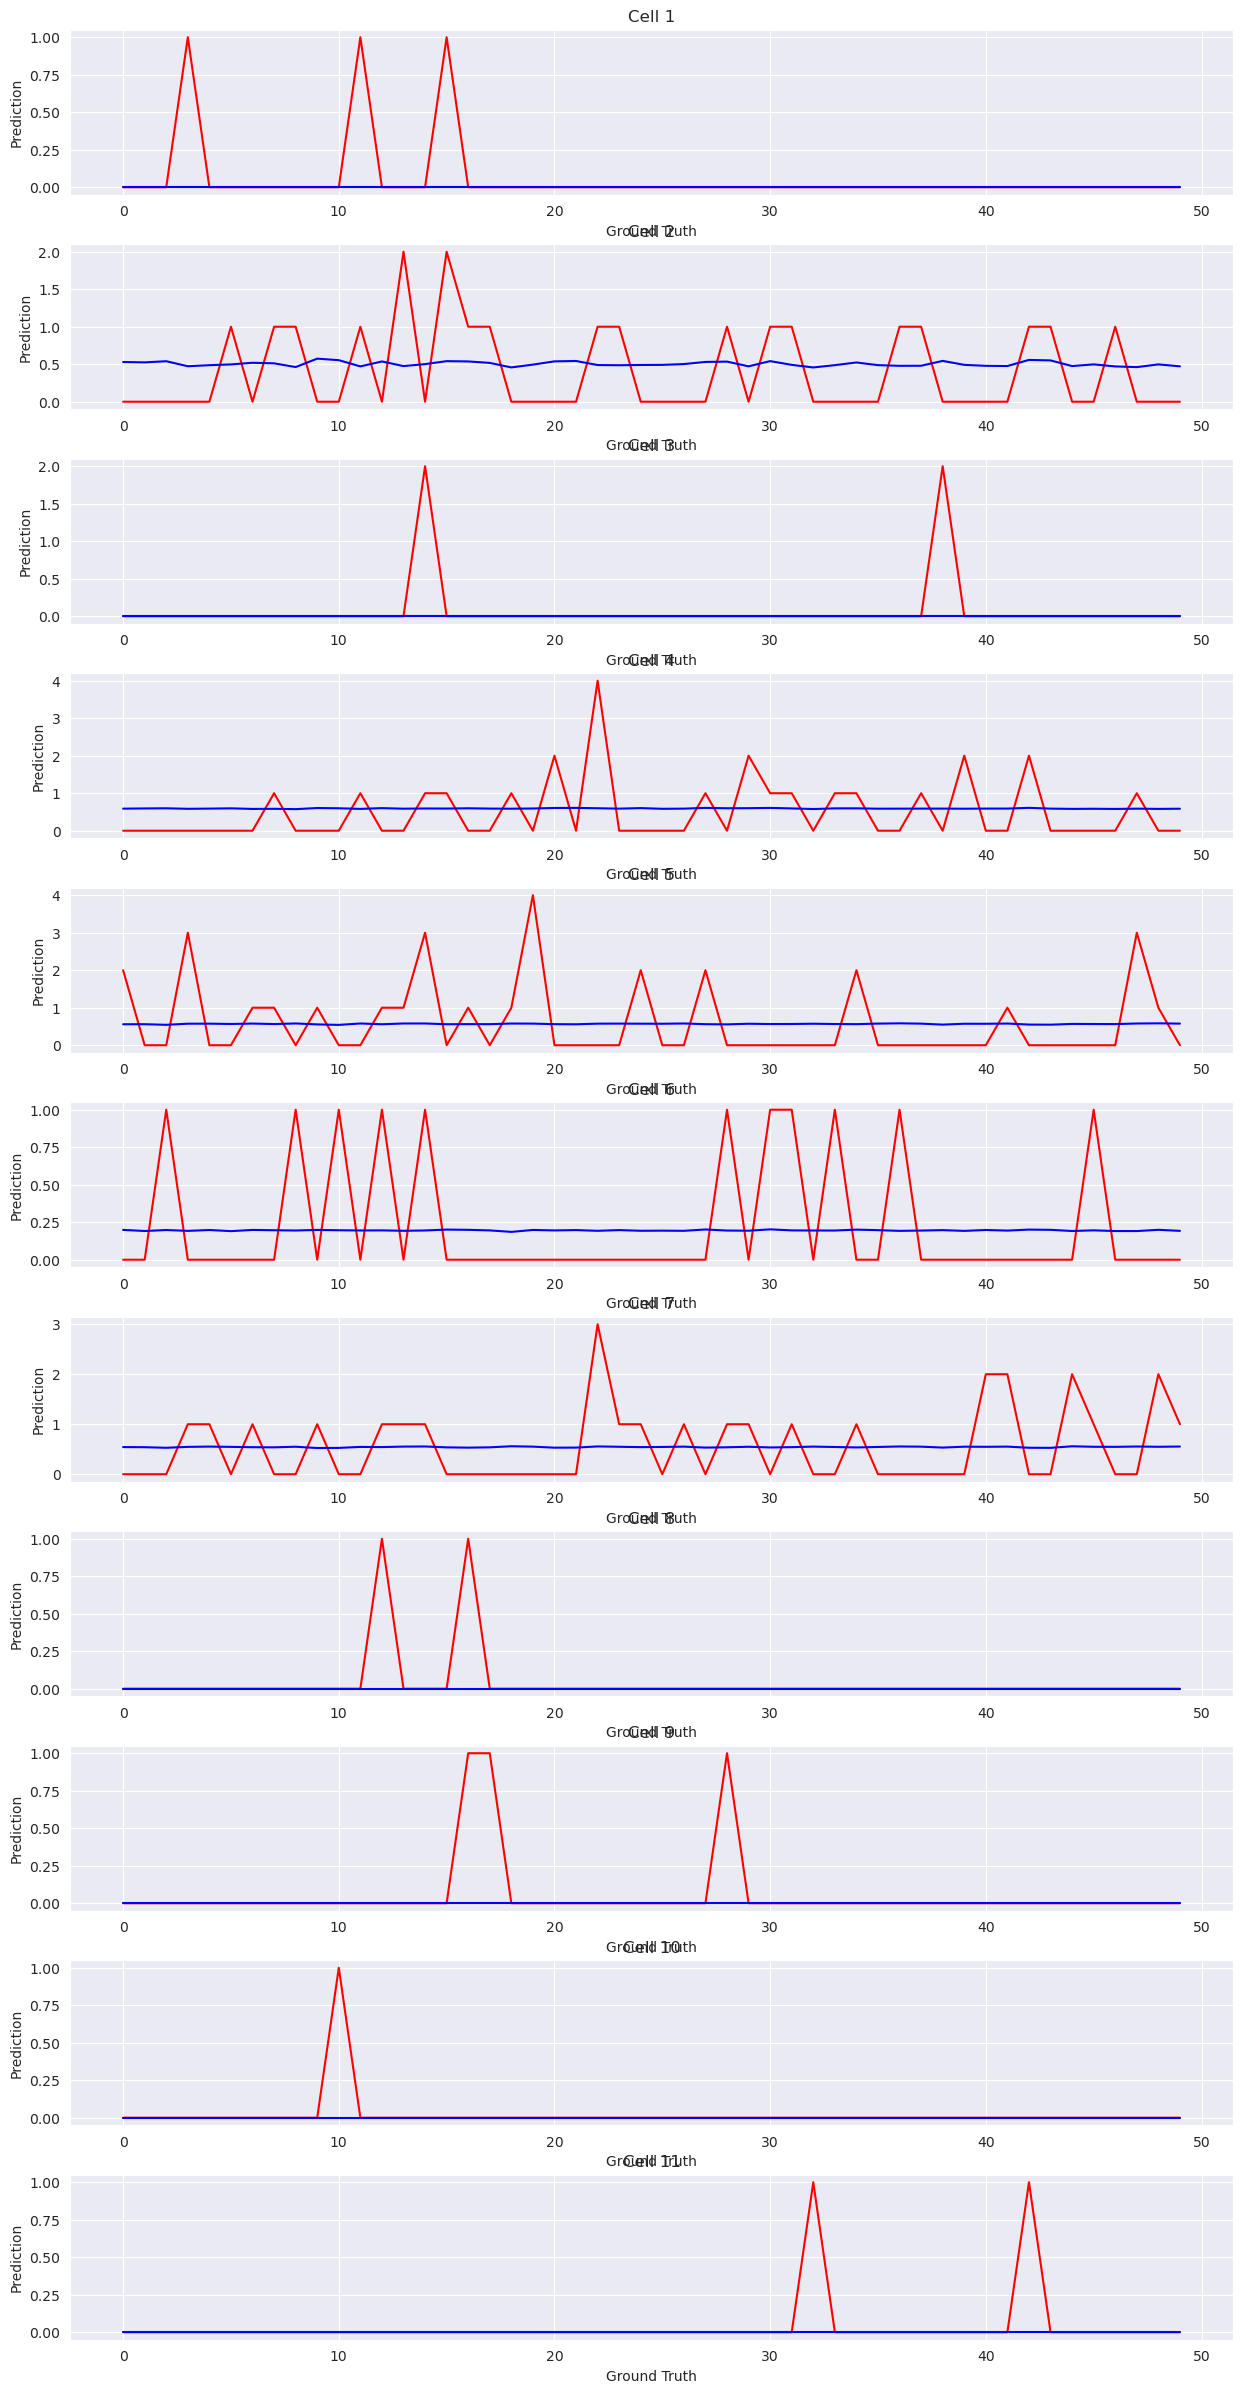

In [39]:
# Calculate R^2 score
r2 = r2_score(all_robs_gt.reshape(-1), all_robs_pred.reshape(-1))
print(f"R^2 score: {r2:.4f}")

# plot the robs compared to the ground truth using grid
# make a grid dataset.NC x 1 plots
# set the size of the figure
plt.figure(figsize=(15, 30))
grid = plt.GridSpec(dataset.NC, 1, wspace=0.4, hspace=0.3)
for c in range(dataset.NC):
    plt.subplot(grid[c, 0])
    plt.plot(all_robs_gt[0, :50, c], c='r')
    plt.plot(all_robs_pred[0, :50, c], c='b')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.title(f"Cell {c + 1}")

# plot the attention weights

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention_weights(attn_weights, layer_idx, head_idx):
    # Select the attention weights for the specific layer and head
    attn = attn_weights[layer_idx][head_idx].detach().cpu().numpy()

    # Calculate the mean attention weights across the batch
    mean_attn = attn.mean(axis=0).mean(axis=0)

    # Create the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(mean_attn, cmap='viridis', square=True)
    plt.title(f'Attention Weights - Layer: {layer_idx + 1}, Head: {head_idx + 1}')
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.show()

In [217]:
with torch.no_grad():
    for batch_idx, batch in enumerate(valid_dl):
        stims = pad_to_reshape(batch['stim'], 100, 36).to(device)
        robs_gt = pad_to_reshape(batch['robs'], 100, 11).to(device)

        robs_pred, attn_weights = v(stims)
        break

attn_weights[0][0].shape

torch.Size([2, 4, 100, 100])

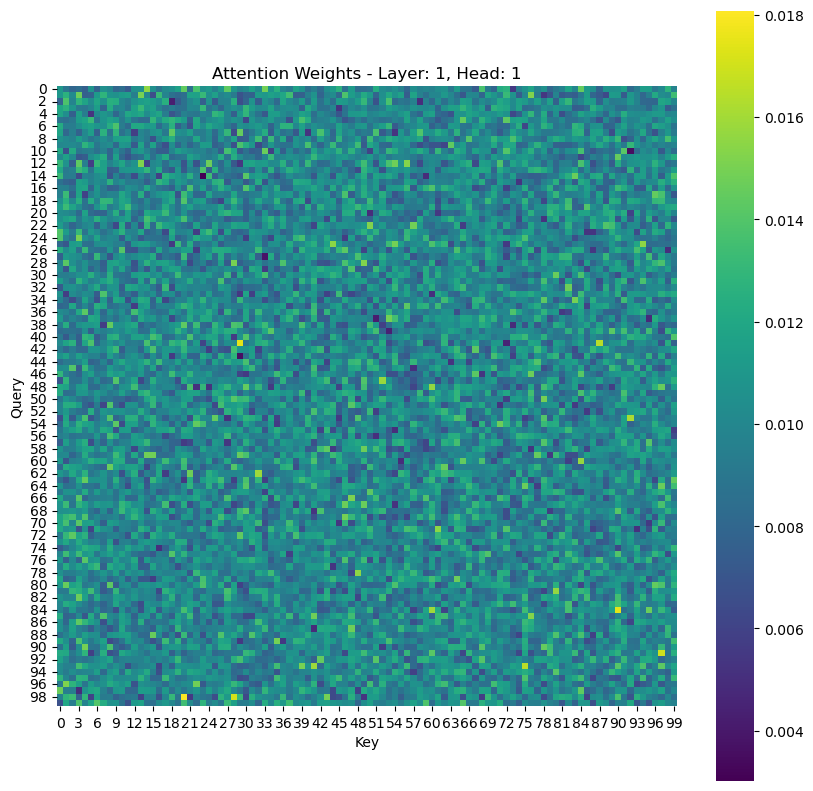

In [219]:
visualize_attention_weights(attn_weights, 0, 0)
# TODO: figure out what this is doing
# TODO: figure out how the network is working to be able to improve it